In [1]:
%%time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Order 66
%config Completer.use_jedi=False
# Ease
import sys
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 70)
sys.path.append("K:\\Projects\\vscProject\\Kaggle\\HousePrices")

Wall time: 2.45 s


In [2]:
%%time
# Coustom Data Module
from Script.data import data

X_train, y_train, X_test, y_samp = data()

Tokenization took: 0.00 ms
Type conversion took: 9.69 ms
Parser memory cleanup took: 0.00 ms
Tokenization took: 10.21 ms
Type conversion took: 10.04 ms
Parser memory cleanup took: 0.00 ms
Tokenization took: 9.82 ms
Type conversion took: 9.99 ms
Parser memory cleanup took: 0.00 ms
Wall time: 3.02 s


In [283]:
print(f"{X_train.shape = }")
print(f"{X_test.shape  = }")

X_train.shape = (1460, 61)
X_test.shape  = (1459, 61)


# helper functions

# sk-learn Imports

In [45]:
%%time

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedKFold
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, VotingRegressor, StackingRegressor

from sklearn.preprocessing import PowerTransformer, RobustScaler, QuantileTransformer
from sklearn.pipeline import Pipeline, make_pipeline

In [4]:
cv = RepeatedKFold(random_state=3007)

In [320]:
def my_sub(y_pred: np.ndarray, file_name: str) -> str:
    y_samp.SalePrice = y_pred
    path_0 = "../Sub/"
    path_1 = ".csv"
    full_path = path_0 + file_name + path_1
    y_samp.astype(np.int64).to_csv(full_path, index=False)
    return full_path



def Pre_Process_Data(X_train, y_train, X_test, y_transformer=None):
    # X_transform
    transformer_pipe_for_X = Pipeline(
        [
            ("normalizer", QuantileTransformer(output_distribution='normal')),
            ("scaler"    , RobustScaler())
        ]
    )
    transformer_pipe_for_y = Pipeline(
        [
            ("normalizer", QuantileTransformer(output_distribution='normal')),
            ("scaler"    , RobustScaler())
        ]
    )
    X_train_scale = pd.DataFrame(transformer_pipe_for_X.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
    X_test_scale  = pd.DataFrame(transformer_pipe_for_X.transform(X_test),columns=X_test.columns,index=X_test.index)
    # y-transform
    y_train_scale = pd.Series(transformer_pipe_for_y.fit_transform(y_train.values.reshape(-1,1)).reshape(-1))
    return X_train_scale, y_train_scale, X_test_scale, transformer_pipe_for_y


X_train_, y_train_, X_test_, y_transform = Pre_Process_Data(X_train, y_train,X_test)



class cmd_rscv:
    def __init__(self, estimator, param_distributions, n_iter=10, *, scoring="neg_mean_absolute_error", n_jobs=-2, cv=cv, verbose=1, random_state=None, **kwargs):
        self.rscv_model = RandomizedSearchCV(
            estimator,
            param_distributions,
            n_iter       = n_iter,
            scoring      = scoring,
            n_jobs       = n_jobs,
            cv           = cv,
            verbose      = verbose,
            random_state = random_state,
            **kwargs
        )
    def doit(self, X_train=X_train_, y=y_train_):
        self.rscv_model.fit(X_train_, y_train_)
        self.cv_data_ = pd.DataFrame(self.rscv_model.cv_results_).sort_values(by="rank_test_score")
        self.best_    = self.rscv_model.best_params_
    def df(self, head=5):
        return self.cv_data_.head(head)
    def best(self):
        return self.best_
    def pred(X_test=X_test_):pass

    


# Decision Tree

In [5]:
%%time
full_dt = DecisionTreeRegressor(criterion="mae")
full_dt.fit(X_train, y_train)

print(f"Tree Depth  = {full_dt.get_depth()}")
print(f"Tree LEaves = {full_dt.get_n_leaves()}")

Tree Depth  = 26
Tree LEaves = 1374
Wall time: 769 ms


In [6]:
full_dt_feature_imp = pd.Series(full_dt.feature_importances_, index=X_train.columns).sort_values(ascending=False).round(4) * 100; full_dt_feature_imp.head(10)

Total_SF        43.15
OverallQual     10.28
Neighborhood    10.00
GrLivArea        4.54
BsmtFinSF1       2.23
Remodel_Age      2.23
GarageArea       1.85
LotFrontage      1.82
LotArea          1.77
MoSold           1.24
dtype: float64

In [7]:
ccpp = pd.DataFrame(full_dt.cost_complexity_pruning_path(X_train, y_train))

In [8]:
ccpp

,ccp_alphas,impurities
0,0.000000,0.000000
1,0.010274,0.010274
2,0.034247,0.044521
3,0.034247,0.078767
4,0.041781,0.120548
...,...,...
1267,1942.673973,29345.836301
1268,2023.165068,31369.001370
1269,3513.057534,34882.058904
1270,5238.838356,40120.897260


In [11]:
%%time
param_distributions = {
    "criterion": ['mae'],
    "ccp_alpha": ccpp.ccp_alphas.values
}

dt_rscv = RandomizedSearchCV(
    DecisionTreeRegressor(),
    param_distributions,
    n_iter       = 100,
    scoring      = "neg_mean_absolute_error",
    n_jobs       = -2,
    cv           = cv,
    verbose      = 1,
    random_state = 7013,
)
dt_rscv.fit(X_train, y_train)

Fitting 50 folds for each of 100 candidates, totalling 5000 fits
Wall time: 23min 44s


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=3007),
                   estimator=DecisionTreeRegressor(), n_iter=100, n_jobs=-2,
                   param_distributions={'ccp_alpha': array([0.00000000e+00, 1.02739726e-02, 3.42465753e-02, ...,
       3.51305753e+03, 5.23883836e+03, 1.54127589e+04]),
                                        'criterion': ['mae']},
                   random_state=7013, scoring='neg_mean_absolute_error',
                   verbose=1)

In [12]:
pd.DataFrame(dt_rscv.cv_results_).sort_values(by="rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,split20_test_score,split21_test_score,split22_test_score,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,split30_test_score,split31_test_score,split32_test_score,split33_test_score,split34_test_score,split35_test_score,split36_test_score,split37_test_score,split38_test_score,split39_test_score,split40_test_score,split41_test_score,split42_test_score,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score
64,0.745176,0.060627,0.005962,0.002642,mae,69.182192,"{'criterion': 'mae', 'ccp_alpha': 69.182191780...",-22838.717466,-24137.402397,-24960.195205,-25154.340753,-22147.013699,-20310.340753,-21906.272260,-25179.222603,-22491.970890,-24736.517123,-24055.712329,-23485.041096,-23565.191781,-21578.708904,-21965.714041,-23060.851027,-20001.698630,-24169.121575,-21837.967466,-23645.618151,-22708.224315,-21910.583904,-21061.416096,-22740.299658,-23344.960616,-23262.207192,-22420.164384,-18855.931507,-22202.958904,-24201.488014,-20220.417808,-25750.936644,-22942.830479,-23448.792808,-22842.532534,-20777.787671,-25527.282534,-22284.217466,-20864.597603,-24734.520548,-22259.755137,-23161.162671,-21472.933219,-25180.392123,-20981.482877,-21786.756849,-21833.928082,-20582.832192,-21804.702055,-25054.952055,-22748.973322,1591.120188,1
72,0.958833,0.235419,0.008358,0.009308,mae,80.821918,"{'criterion': 'mae', 'ccp_alpha': 80.821917808...",-24265.217466,-23718.717466,-23205.351027,-25202.063356,-22074.000000,-19572.751712,-21449.587329,-23871.513699,-22995.738014,-25646.226027,-24483.914384,-22214.893836,-22857.366438,-21210.104452,-23248.232877,-22775.511986,-19458.638699,-23906.011986,-21788.183219,-22790.602740,-23338.017123,-22570.547945,-21633.936644,-22956.297945,-22667.416096,-23014.176370,-22721.465753,-18852.667808,-21699.743151,-24093.897260,-19661.407534,-24825.159247,-23739.710616,-24142.690068,-22403.845890,-20970.041096,-24835.224315,-22134.477740,-21539.789384,-25573.544521,-22697.023973,-22163.594178,-22786.761986,-24958.797945,-21772.107877,-24195.842466,-21567.660959,-20863.066781,-22211.563356,-25790.799658,-22782.318048,1594.986417,2
25,0.852104,0.053867,0.006354,0.002674,mae,64.641096,"{'criterion': 'mae', 'ccp_alpha': 64.641095890...",-23645.703767,-24693.308219,-25172.224315,-25956.902397,-22677.150685,-19817.520548,-20970.142123,-24137.671233,-22604.842466,-25594.726027,-24373.410959,-22718.638699,-22854.476027,-22025.693493,-23081.642123,-21707.412671,-20919.477740,-24360.626712,-22309.143836,-22692.241438,-23164.428082,-22068.464041,-22059.470890,-22781.246575,-23221.672945,-23755.871575,-23600.494863,-19076.924658,-21571.402397,-23605.323630,-20169.984589,-25869.126712,-22949.556507,-22956.761986,-22700.481164,-21450.308219,-24936.289384,-22315.441781,-21557.035959,-25276.250000,-22527.746575,-22737.936644,-21497.544521,-24995.724315,-20251.859589,-22100.972603,-21739.056507,-20698.443493,-21727.789384,-26458.751712,-22842.706336,1646.785304,3
95,1.032127,0.247019,0.008588,0.006447,mae,54.547945,"{'criterion': 'mae', 'ccp_alpha': 54.547945205...",-23915.590753,-24208.465753,-23360.071918,-26010.583904,-22847.469178,-19421.719178,-20787.371575,-23782.962329,-23191.614726,-24879.212329,-23289.361301,-22622.484589,-24027.630137,-22507.583904,-23459.922945,-24152.820205,-20001.106164,-23758.056507,-21336.107877,-22880.232877,-22882.785959,-22358.393836,-20

tree Depth  = 11
tree Leaves = 78


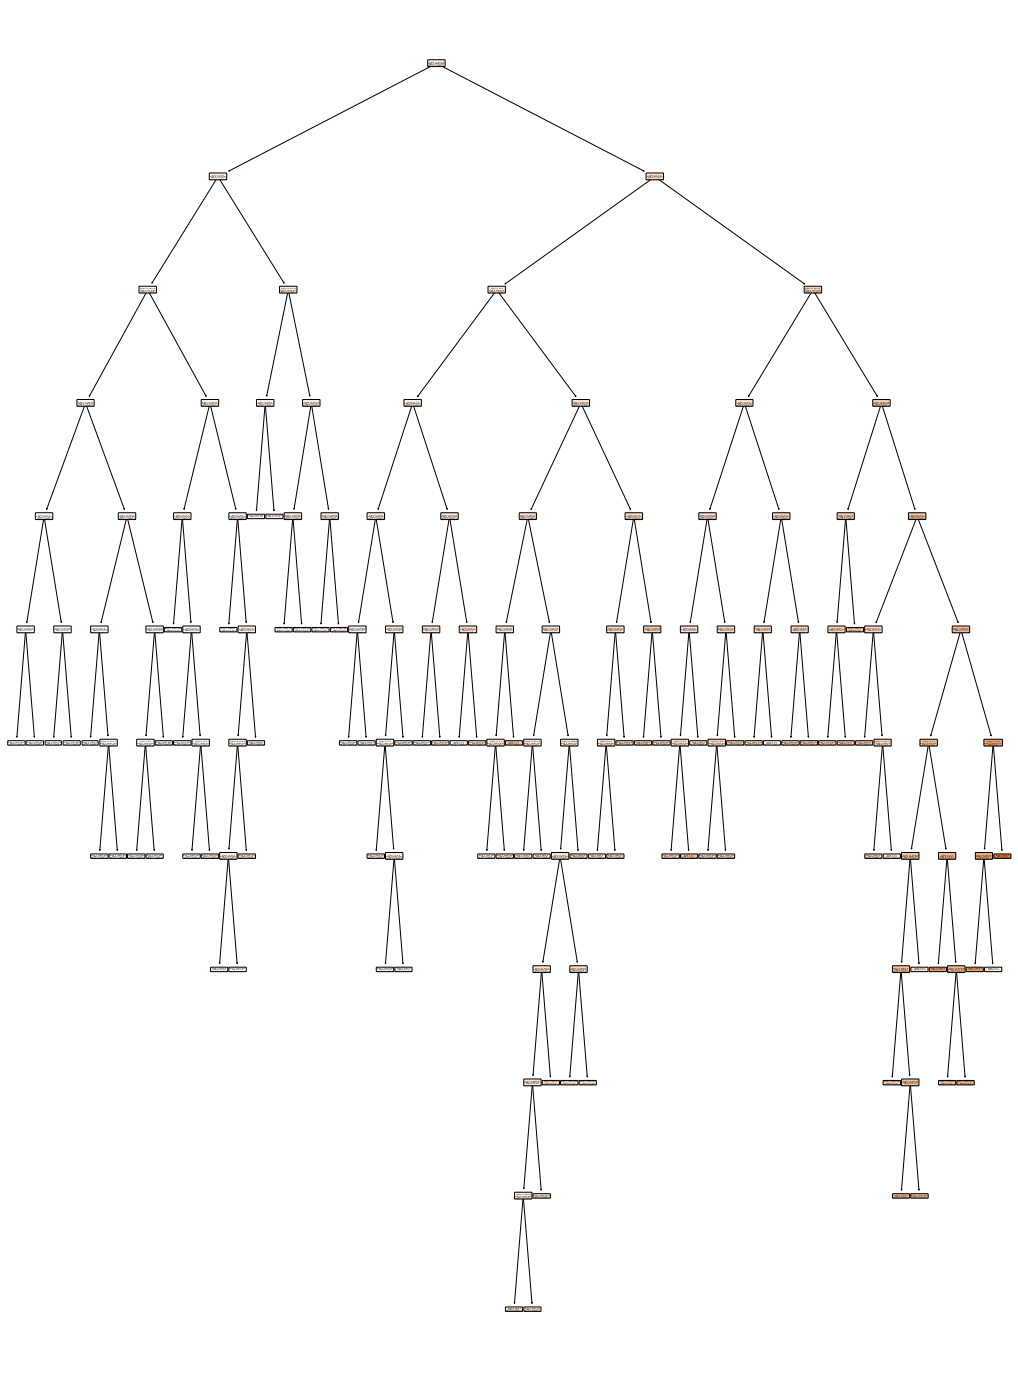

Wall time: 25 s


In [19]:
%%time
# Get Best Param
full_dt_best_param = dt_rscv.best_params_
# Form the Best Decision Tree
best_dt = DecisionTreeRegressor(**full_dt_best_param)
# Fit the Tree
best_dt.fit(X_train, y_train)
# Print Tree Data
print("tree Depth  = {}".format(best_dt.get_depth()))
print("tree Leaves = {}".format(best_dt.get_n_leaves()))
# Plot Tree
fig, ax = plt.subplots(1,1, figsize=(18,25))
plot_tree(best_dt, filled=True, rounded=True, ax=ax)
plt.show()

In [20]:
best_dt_feature_imp = pd.Series(best_dt.feature_importances_, index=X_train.columns).sort_values(ascending=False).round(4) * 100
best_dt_feature_imp.head(10)

Total_SF        54.77
OverallQual     12.99
Neighborhood    12.29
GrLivArea        4.18
BsmtFinSF1       1.93
YearRemodAdd     1.47
BsmtQual         1.21
KitchenQual      1.14
GarageCars       1.10
GarageYrBlt      0.93
dtype: float64

# RandomForestRegrssor

In [35]:
%%time

param_distributions = {
    "criterion"   : ['mae'],
    "n_estimators": [30],
    "verbose"     : [1],
    "n_jobs"      : [-2],
    "ccp_alpha"   : ccpp.ccp_alphas.values
}

rf_gscv = RandomizedSearchCV(
    RandomForestRegressor(),
    param_distributions,
    n_iter = 30,
    scoring = "neg_mean_absolute_error",
    n_jobs  = -2,
    cv      = cv,
    verbose = 1,
)

rf_gscv.fit(X_train, y_train)

Fitting 50 folds for each of 30 candidates, totalling 1500 fits


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.


Wall time: 1h 15min 32s


[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:    5.1s finished


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=3007),
                   estimator=RandomForestRegressor(), n_iter=30, n_jobs=-2,
                   param_distributions={'ccp_alpha': array([0.00000000e+00, 1.02739726e-02, 3.42465753e-02, ...,
       3.51305753e+03, 5.23883836e+03, 1.54127589e+04]),
                                        'criterion': ['mae'],
                                        'n_estimators': [30], 'n_jobs': [-2],
                                        'verbose': [1]},
                   scoring='neg_mean_absolute_error', verbose=1)

In [38]:
pd.DataFrame(rf_gscv.cv_results_).sort_values(by="rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_verbose,param_n_jobs,param_n_estimators,param_criterion,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,split20_test_score,split21_test_score,split22_test_score,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,split30_test_score,split31_test_score,split32_test_score,split33_test_score,split34_test_score,split35_test_score,split36_test_score,split37_test_score,split38_test_score,split39_test_score,split40_test_score,split41_test_score,split42_test_score,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score
26,7.735773,0.690399,0.999529,0.670483,1,-2,30,mae,1.369863,"{'verbose': 1, 'n_jobs': -2, 'n_estimators': 3...",-15884.977568,-18604.180194,-16290.557477,-18082.750685,-15363.426541,-15499.804110,-16409.912728,-16777.490582,-17139.947374,-18570.503995,-17726.097146,-17417.072888,-16080.396861,-16405.483048,-15844.994349,-16262.011301,-15868.630822,-17278.399543,-17217.390868,-16930.412386,-16705.199486,-15213.547489,-15590.675000,-17902.002283,-17758.953025,-17245.011473,-14960.038642,-16739.604737,-17794.510046,-16168.473744,-16085.167409,-16739.358390,-17774.135445,-18424.811073,-15782.389384,-15550.517352,-17570.981678,-15560.263242,-15470.661929,-18434.431279,-16718.097717,-14513.344463,-15895.942466,-19678.944521,-16226.896290,-16055.001655,-17398.038984,-14567.309132,-17153.905993,-18521.393836,-16717.080973,1142.232561,1
11,8.116541,0.422800,0.818787,0.243186,1,-2,30,mae,11.780822,"{'verbose': 1, 'n_jobs': -2, 'n_estimators': 3...",-16779.981735,-17698.879566,-16277.044235,-17687.158276,-15177.807591,-15512.468836,-16373.848402,-16590.653482,-17873.967409,-19040.498916,-17825.555308,-16564.032534,-15807.974715,-16714.736872,-16534.674829,-16531.875400,-15775.048973,-16957.885731,-16966.892694,-17256.603196,-16719.673687,-14819.935788,-15478.780765,-18456.827568,-17913.515468,-17520.061416,-15503.443607,-15430.951313,-17917.764441,-15416.680422,-15664.862785,-16695.439498,-17245.739669,-18499.535731,-15496.525057,-15715.030080,-17790.141553,-16460.979623,-16233.893208,-19330.108619,-15445.397432,-15241.495434,-16797.562100,-19604.594178,-16424.386416,-15910.021632,-17241.651655,-14455.683219,-17628.287100,-17796.908390,-16736.069331,1168.875464,2
21,8.133227,0.256096,0.779854,0.132490,1,-2,30,mae,4.156164,"{'verbose': 1, 'n_jobs': -2, 'n_estimators': 3...",-16303.600000,-17944.744121,-16789.827340,-17725.436416,-15222.316667,-15619.079452,-16911.038927,-16864.035845,-17001.871005,-18757.391838,-18237.842466,-17066.756164,-16374.692979,-17086.331507,-15536.795947,-17061.540925,-15168.671747,-17493.868037,-16361.902568,-16606.821290,-16233.948973,-15322.051541,-15274.915639,-18682.819007,-17674.250571,-17365.672888,-15683.720776,-15761.212785,-17882.687215,-16236.524030,-15693.696005,-17139.656450,-17423.265868,-18531.989954,-16112.770034,-14771.983790,-17982.140411,-16129.099943,-15977.260674,-18667.598687,-15682.678881,-14830.685160,-16282.665468,-19300.677568,-16360.641381,-15563.793322,-18595.128995,-14927.075514,-16959.301142,-18032.485845,-16744.339275,1163.714830,3
6,8.224688,0.415023,0.724567,0.312955,1,-2,30,mae,6.164384,"{'verbose': 1, 'n_jobs': -2, 'n_estimators': 3...",-16152.300457,-18218.593208,-17172.573916,-17887.307021,-14875.496918,-15113.692979,-16544.908562,-17002.608619,-17679.282877,-18940.748002,-17969.078368,-17290.197603,-16102.733390,-16655.088356,-15994.833676,-16535.898973,-15618.604680

In [47]:
%%time

rf_best_params = pd.DataFrame(rf_gscv.cv_results_).sort_values(by="rank_test_score").head(5).params.values

rf_model_list = []

for num, model in enumerate(rf_best_params):
    rf_model_list.append(("model"+str(num), RandomForestRegressor(**model)))

rf_vote_5 = VotingRegressor(rf_model_list, n_jobs= -2, verbose = True)

rf_vote_5.fit(X_train, y_train)

In [238]:
y_pred = rf_vote_5.predict(X_test)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:    0.1s finished


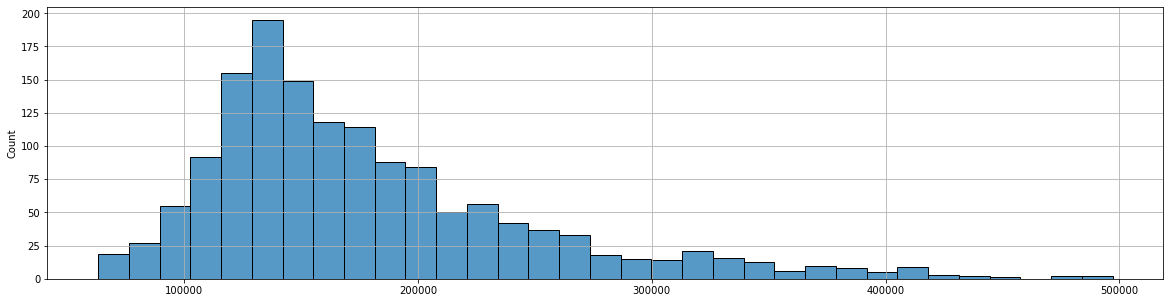

In [239]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
sns.histplot(y_pred, ax=ax)
plt.grid()
plt.show()

In [69]:
my_sub(y_pred, "rf_vote")

'../Sub/rf_vote.csv'

# XG Boost

In [170]:
from xgboost import XGBRegressor, XGBRFRegressor
from scipy.stats import randint, uniform

In [171]:
xgb_regr   = XGBRegressor()
xgbrf_regr = XGBRFRegressor()

In [172]:
%%time

param_distributions = {
    "n_estimators" : randint(90, 500),
    "max_depth"   : randint(3,100),
    "learning_rate": uniform(0.00001, 0.2),
    "verbosity"    : [1]
}

xgb_gscv = RandomizedSearchCV(
    XGBRegressor(),
    param_distributions,
    n_iter       = 20,
    scoring      = "neg_mean_absolute_error",
    n_jobs       = -2,
    cv           = cv,
    verbose      = 1,
    random_state = 4575,
)

Wall time: 6 ms


In [173]:
%%time
xgb_gscv.fit(X_train, y_train)

Fitting 50 folds for each of 20 candidates, totalling 1000 fits
Wall time: 1h 11min 9s


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=3007),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, m...
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002557C5EF220>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000255746A1E20>,
             

In [175]:
pd.DataFrame(xgb_gscv.cv_results_).sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_verbosity,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,split20_test_score,split21_test_score,split22_test_score,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,split30_test_score,split31_test_score,split32_test_score,split33_test_score,split34_test_score,split35_test_score,split36_test_score,split37_test_score,split38_test_score,split39_test_score,split40_test_score,split41_test_score,split42_test_score,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score
15,3.664000,0.174814,0.010991,0.002082,0.161034,4,412,1,"{'learning_rate': 0.1610336067328284, 'max_dep...",-14172.435039,-14904.782788,-14109.409180,-16854.794440,-15296.090071,-14127.185346,-14366.001712,-15807.613669,-16628.309610,-18034.054514,-15849.742268,-15468.547196,-15670.601469,-15402.816647,-14739.191072,-16668.541899,-13840.043156,-15706.722991,-15169.409153,-15769.241037,-14280.998763,-15929.716703,-13676.991438,-16313.284528,-16908.226429,-15692.847242,-14021.330051,-13939.692918,-15908.637762,-15909.447466,-14015.296661,-15712.944777,-14775.291350,-16391.334948,-14982.166230,-15172.183754,-15198.792434,-14308.181092,-14877.673266,-16861.168664,-14286.999666,-14106.805303,-14124.105576,-18428.771979,-14547.350947,-14896.821918,-16763.265571,-13184.417822,-15058.910076,-16662.846506,-15310.440702,1132.813778,1
6,1.554486,0.146181,0.009325,0.001586,0.18915,5,169,1,"{'learning_rate': 0.18915048554463787, 'max_de...",-14370.410049,-15731.764140,-15356.686791,-16836.232181,-16168.430731,-14011.840727,-14952.688048,-15203.669494,-17949.097041,-18336.051303,-16713.238415,-15076.245733,-16088.453767,-16306.035531,-15435.347844,-15780.146618,-14683.079877,-15200.574955,-15576.678484,-17540.906665,-14224.536494,-16104.791524,-14726.664892,-17392.478221,-16375.790481,-15941.487265,-14172.004227,-14321.265652,-15879.614699,-16896.686470,-13949.742268,-16416.350800,-16463.495090,-16033.171714,-14851.781477,-15874.124090,-16301.804032,-14355.405675,-15620.071731,-17720.735164,-14779.960884,-13639.828045,-14911.211125,-18973.623756,-14057.917407,-15150.636692,-17013.008374,-13389.940363,-15537.263766,-16970.990060,-15707.279217,1245.250122,2
18,4.356714,0.322352,0.011262,0.001837,0.046688,11,154,1,"{'learning_rate': 0.046687677215770926, 'max_d...",-14591.124171,-15874.361810,-15233.375120,-17054.562687,-17088.246522,-14800.120719,-15547.046032,-15737.746321,-17188.741679,-18276.639876,-16249.463345,-15595.367963,-15522.073924,-16502.545189,-15339.250080,-15798.891588,-15308.751739,-15588.361957,-16071.174591,-16810.651969,-14705.088158,-15898.342760,-14597.890491,-18205.564881,-17337.269237,-16426.300808,-13147.163808,-14900.260301,-16995.343402,-17337.826921,-13896.446570,-16299.216636,-16122.916872,-17001.075209,-15201.834453,-15566.435132,-16018.743418,-15093.778949,-15454.639046,-18040.777330,-14610.279297,-13770.964710,-14581.073028,-17844.222175,-14533.847723,-15506.882679,-17035.174203,-13318.615984,-15391.277839,-16680.546755,-15833.965921,1203.069106,3
2,10.975059,0.426398,0.015276,0.003332,0.024708,83,287,1,"{'learning_rate': 0.02470754795215602, 'max_de...",-14762.178256,-16035.576760,-15157.706403,-17124.344151,-16987.916283,-14585.011371,-15366.932577,-15537.085282,-17524.928109,-18234.338854,-16289.414678,-15306.811871,-15594.220115,-16351.409059,-15058.949847,-15699.957941,-15477.929995,-15776.519117,-16504.6

In [101]:
%%time

xgb_best = XGBRegressor(**xgb_gscv.best_params_, random_state=100)

xgb_best.fit(X_train, y_train)

Wall time: 2.5 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1610336067328284, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=412, n_jobs=4, num_parallel_tree=1, random_state=100,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=1)

In [110]:
%%time

list_best_xgb = []

for n, rs in enumerate(randint(0, 1_000_000).rvs(size=100, random_state=1995)):
    list_best_xgb.append(
        ("model_"+str(n), XGBRegressor(**xgb_gscv.best_params_, random_state=rs))
    )

Wall time: 57.1 ms


In [112]:
%%time

xgb_vote = VotingRegressor(
    list_best_xgb,
    n_jobs  = -2,
    verbose = True
)

xgb_vote.fit(X_train, y_train)

Wall time: 2min 16s


VotingRegressor(estimators=[('model_0',
                             XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=0.1610336067328284,
                                          max_delta_step=None, max_depth=4,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_...
                                          interaction_constraints=None,
                                          learning_rate=0.1610336067328284,
                                 

In [236]:
y_pred = xgb_vote.predict(X_test)

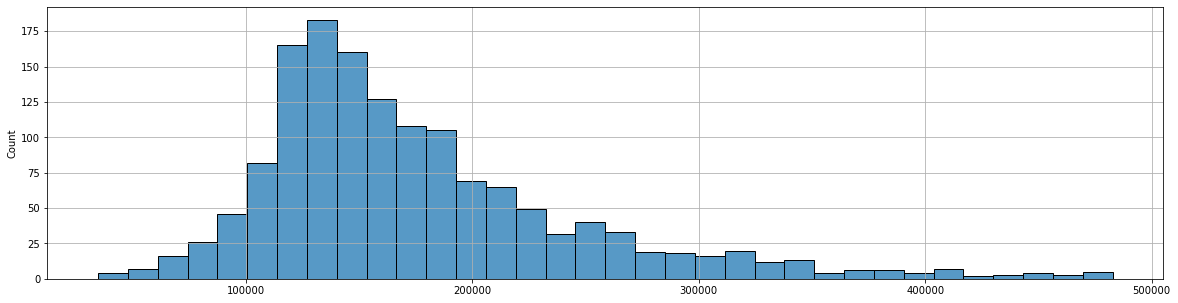

In [237]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
sns.histplot(y_pred, ax=ax)
plt.grid()
plt.show()

In [114]:
my_sub(y_pred, "xgb_voting_100")

'../Sub/xgb_voting_100.csv'

# TF

In [201]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [204]:
#

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 500)               31000     
_________________________________________________________________
dense_53 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_54 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_55 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 251       
Total params: 657,501
Trainable params: 657,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
32/32 [==============================] - 1s 21ms/step - loss: 0.6035 - mean_absolute_error: 0.6035 - v

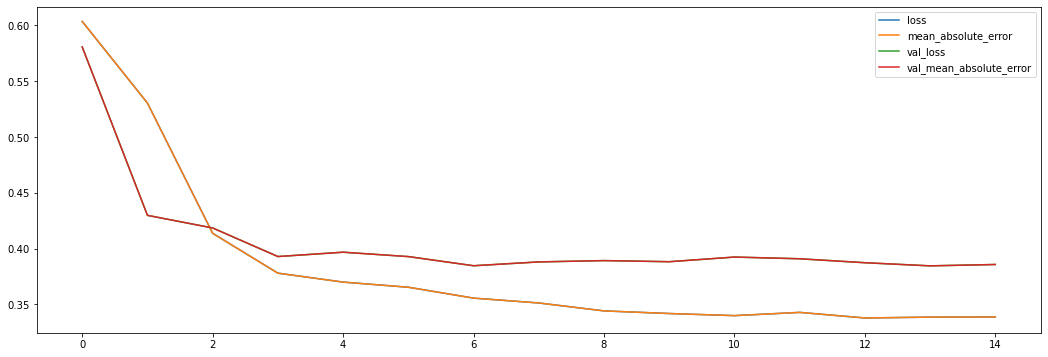

In [216]:
model = Sequential(
    [
        Dense(500, input_shape=X_train.shape[1:], activation='relu'),
        Dense(500, activation='relu'),
        Dense(500, activation='relu'),
        Dense(250, activation='relu'),
        Dense(1,   activation='relu')
    ]
)

model.summary()

model.compile(
    optimizer = Adam(learning_rate=0.0001),
    loss      = "mean_absolute_error",
    metrics   = "mean_absolute_error",
)

history = model.fit(X_train_, y_train_, epochs=15, validation_split=0.3)

fig, ax = plt.subplots(1,1, figsize=(18,6))
pd.DataFrame(history.history).plot(kind='line', ax=ax)
plt.grid()
plt.show()

In [232]:
y_pred_ = model.predict(X_test_)

In [233]:
y_pred = y_transform.inverse_transform(y_pred_).astype(np.int64).reshape(-1)

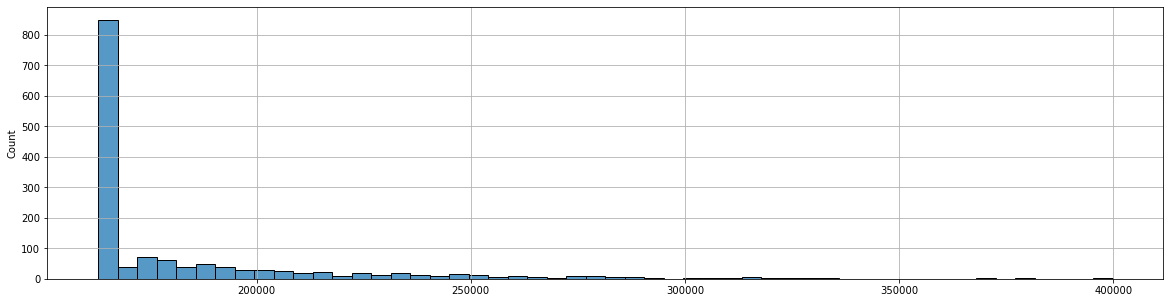

In [234]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
sns.histplot(y_pred, ax=ax)
plt.grid()
plt.show()

In [235]:
my_sub(y_pred, 'simple_ann')

'../Sub/simple_ann.csv'

# **Linear Models**

In [335]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet


def lin_reg(linreg):
    linreg.fit(X_train_, y_train_)

    y_pred_ = linreg.predict(X_test_)

    y_pred = y_transform.inverse_transform(y_pred_.reshape(-1,1)).astype(np.int64)

    fig, ax = plt.subplots(1,1, figsize=(20,5))
    sns.histplot(y_pred, ax=ax)
    plt.grid()
    plt.show()
    print(pd.Series(linreg.coef_,index=X_train.columns).loc[pd.Series(linreg.coef_,index=X_train.columns).abs().sort_values(ascending=False).index].head(15))
    return y_pred

## Linear Regression

In [341]:
%%time

param_dict = {
    "fit_intercept": [True, False],
    "normalize"    : [True, False],
    "positive"     : [True, False],
}

lr_gscv = GridSearchCV(
    LinearRegression(),
    param_dict,
    scoring = 'neg_mean_absolute_error',
    n_jobs  = -2,
    cv      = cv,
    verbose = 1,
    
)

lr_gscv.fit(X_train_, y_train_)

pd.DataFrame(lr_gscv.cv_results_).sort_values(by="rank_test_score")

Fitting 50 folds for each of 8 candidates, totalling 400 fits
Wall time: 12.4 s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_fit_intercept,param_normalize,param_positive,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,split20_test_score,split21_test_score,split22_test_score,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,split30_test_score,split31_test_score,split32_test_score,split33_test_score,split34_test_score,split35_test_score,split36_test_score,split37_test_score,split38_test_score,split39_test_score,split40_test_score,split41_test_score,split42_test_score,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score
1,0.017677,0.004830,0.006195,0.003356,True,True,False,"{'fit_intercept': True, 'normalize': True, 'po...",-0.154998,-0.171657,-0.161894,-0.176752,-0.155829,-0.163129,-0.158336,-0.163349,-0.169202,-0.182864,-0.172257,-0.158081,-0.157517,-0.165563,-0.177210,-0.166113,-0.163989,-0.170150,-0.175210,-0.161227,-0.162304,-0.170607,-0.156511,-0.179029,-0.161370,-0.167124,-0.154824,-0.172902,-0.156018,-0.176284,-0.164903,-0.174343,-0.155290,-0.181573,-0.159548,-0.153783,-0.169179,-0.175996,-0.163364,-0.166906,-0.152713,-0.162362,-0.168379,-0.180996,-0.167698,-0.156367,-0.182483,-0.145045,-0.159320,-0.171246,-0.165876,0.008850,1
3,0.017894,0.005847,0.006752,0.003356,True,False,False,"{'fit_intercept': True, 'normalize': False, 'p...",-0.154998,-0.171657,-0.161894,-0.176752,-0.155829,-0.163129,-0.158336,-0.163349,-0.169202,-0.182864,-0.172257,-0.158081,-0.157517,-0.165563,-0.177210,-0.166113,-0.163989,-0.170150,-0.175210,-0.161227,-0.162304,-0.170607,-0.156511,-0.179029,-0.161370,-0.167124,-0.154824,-0.172902,-0.156018,-0.176284,-0.164903,-0.174343,-0.155290,-0.181573,-0.159548,-0.153783,-0.169179,-0.175996,-0.163364,-0.166906,-0.152713,-0.162362,-0.168379,-0.180996,-0.167698,-0.156367,-0.182483,-0.145045,-0.159320,-0.171246,-0.165876,0.008850,2
5,0.021885,0.006011,0.010325,0.005624,False,True,False,"{'fit_intercept': False, 'normalize': True, 'p...",-0.153982,-0.171999,-0.162491,-0.177079,-0.156659,-0.163267,-0.158283,-0.164105,-0.169723,-0.183882,-0.172392,-0.158309,-0.158447,-0.165502,-0.177687,-0.166461,-0.164603,-0.170205,-0.175548,-0.162015,-0.163149,-0.171271,-0.157286,-0.177162,-0.161374,-0.168426,-0.154680,-0.173238,-0.156533,-0.175327,-0.165073,-0.173719,-0.156190,-0.182300,-0.159320,-0.154647,-0.169095,-0.176676,-0.163082,-0.167727,-0.152620,-0.162789,-0.168853,-0.181074,-0.168771,-0.157294,-0.183493,-0.145978,-0.158991,-0.171387,-0.166203,0.008799,3
7,0.021104,0.006637,0.010147,0.005638,False,False,False,"{'fit_intercept': False, 'normalize': False, '...",-0.153982,-0.171999,-0.162491,-0.177079,-0.156659,-0.163267,-0.158283,-0.164105,-0.169723,-0.183882,-0.172392,-0.158309,-0.158447,-0.165502,-0.177687,-0.166461,-0.164603,-0.170205,-0.175548,-0.162015,-0.163149,-0.171271,-0.157286,-0.177162,-0.161374,-0.168426,-0.154680,-0.173238,-0.156533,-0.175327,-0.165073,-0.173719,-0.156190,-0.182300,-0.159320,-0.154647,-0.169095,-0.176676,-0.163082,-0.167727,-0.152620,-0.162789,-0.168853,-0.181074,-0.168771,-0.157294,-0.183493,-0.145978,-0.158991,-0.171387,-0.166203,0.008799,3
4,0.035774,0.008875,0.010548,0.005185,False,True,True,"{'fit_intercept': False, 'normalize': True, 'p...",-0.153674,-0.176821,-0.169061,-0.185844,-0.154610,-0.164506,-0.161110,-0.168953,-0.172244,-0.179378,-0.170089,-0.166876,-0.155064,-0.172403,-0.178214,-0.160099,-0.172142,-0.171650,-0.175214,-0.165596,-0.163185,-0.176426,-0.160116,-0.177161,-0.164133,-0.170742,-0.161028,-0.17687

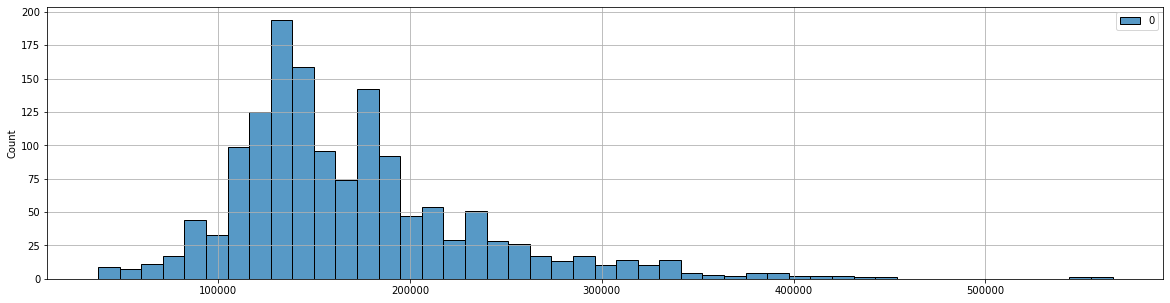

Total_SF        0.317035
GrLivArea       0.195708
OverallQual     0.114253
Floors_no      -0.098093
GarageYrBlt     0.094850
Neighborhood    0.085006
Foundation      0.078569
OverallCond     0.077975
Age_Garage      0.075285
GarageArea     -0.071628
BsmtFinSF1      0.069584
Fireplaces      0.069456
TotalBsmtSF    -0.064839
LotArea         0.063500
HeatingQC      -0.046411
dtype: float64


In [342]:
y_pred = lin_reg(LinearRegression(**lr_gscv.best_params_))

## Lasso

In [343]:
%%time

param_distributions = {
    "alpha"        : uniform(0.0001, 1),
    "fit_intercept": [True, False],
    "normalize"    : [True, False],
    "max_iter"     : [100_000],
    "tol"          : [0.00001]
}

lasso_rscv = cmd_rscv(Lasso(), param_distributions, 500, random_state = 1854)

lasso_rscv.doit()

lasso_rscv.df()

Fitting 50 folds for each of 500 candidates, totalling 25000 fits
Wall time: 3min 44s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_fit_intercept,param_max_iter,param_normalize,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,split20_test_score,split21_test_score,split22_test_score,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,split30_test_score,split31_test_score,split32_test_score,split33_test_score,split34_test_score,split35_test_score,split36_test_score,split37_test_score,split38_test_score,split39_test_score,split40_test_score,split41_test_score,split42_test_score,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score
320,0.029406,0.004284,0.006877,0.001937,0.003673,False,100000,True,0.00001,"{'alpha': 0.003672588612562044, 'fit_intercept...",-0.158305,-0.174114,-0.165400,-0.178684,-0.153727,-0.162873,-0.159208,-0.164693,-0.171155,-0.183327,-0.168145,-0.161543,-0.157949,-0.168860,-0.176655,-0.161329,-0.165748,-0.170217,-0.176008,-0.165079,-0.159985,-0.172191,-0.158556,-0.181848,-0.161711,-0.172166,-0.157373,-0.176103,-0.158601,-0.169033,-0.165420,-0.173687,-0.159987,-0.185042,-0.151299,-0.154314,-0.167696,-0.178875,-0.160472,-0.171636,-0.155334,-0.155944,-0.170866,-0.180726,-0.170512,-0.159136,-0.184499,-0.148174,-0.161197,-0.171330,-0.166735,0.009055,1
234,0.023989,0.004290,0.009304,0.007347,0.0091,False,100000,False,0.00001,"{'alpha': 0.009099968961639681, 'fit_intercept...",-0.167713,-0.179758,-0.171444,-0.182548,-0.156593,-0.166069,-0.163632,-0.170181,-0.177275,-0.183047,-0.172396,-0.169153,-0.160058,-0.175461,-0.179435,-0.162302,-0.168595,-0.176030,-0.181149,-0.172044,-0.163634,-0.175443,-0.162554,-0.185961,-0.166526,-0.177505,-0.162490,-0.178865,-0.165331,-0.173361,-0.167378,-0.176263,-0.168451,-0.191520,-0.152843,-0.157678,-0.170953,-0.186687,-0.163568,-0.176806,-0.161659,-0.158077,-0.173016,-0.185351,-0.175080,-0.164076,-0.187691,-0.153344,-0.165596,-0.174784,-0.171147,0.009160,2
57,0.026511,0.007265,0.009919,0.005097,0.01616,False,100000,True,0.00001,"{'alpha': 0.016159683668997792, 'fit_intercept...",-0.177765,-0.187455,-0.175615,-0.187377,-0.161681,-0.171186,-0.169675,-0.177549,-0.182139,-0.185450,-0.178100,-0.178665,-0.163076,-0.182035,-0.182947,-0.165928,-0.173978,-0.184032,-0.189927,-0.177454,-0.169378,-0.180045,-0.167420,-0.193891,-0.173207,-0.184168,-0.169923,-0.182408,-0.173944,-0.178198,-0.171828,-0.179594,-0.173522,-0.198594,-0.161665,-0.162249,-0.177197,-0.196416,-0.168395,-0.180640,-0.168820,-0.163226,-0.177712,-0.192292,-0.178605,-0.171413,-0.190007,-0.161167,-0.172872,-0.181536,-0.177047,0.009228,3
474,0.023831,0.007370,0.009114,0.003413,0.017581,False,100000,True,0.00001,"{'alpha': 0.017580748888169084, 'fit_intercept...",-0.179021,-0.188677,-0.176359,-0.187998,-0.162237,-0.172321,-0.170801,-0.179208,-0.183108,-0.185884,-0.179069,-0.179595,-0.164057,-0.182959,-0.183093,-0.166421,-0.174678,-0.185238,-0.191462,-0.177961,-0.170617,-0.180579,-0.168403,-0.195400,-0.174354,-0.184903,-0.171185,-0.182696,-0.175885,-0.179384,-0.172978,-0.180178,-0.174938,-0.199204,-0.163818,-0.163399,-0.178227,-0.198601,-0.169271,-0.180941,-0.170521,-0.164250,-0.178860,-0.193193,-0.178919,-0.172895,-0.190526,-0.162810,-0.173795,-0.182609,-0.178070,0.009167,4
208,0.018586,0.004325,0.007716,0.003962,0.017637,False,100000,True,0.00001,"{'alpha': 0.017636555562456035, 'fit_intercept...",-0.179069,-0.188721,-0.176393,-0.188024,-0.162260,-0.172370,-0.170833,-0.179278,-0.183147,-0.185897,-0.179101,-0.179630,-0.164098,-0.182993,-0.183102,-0.16644

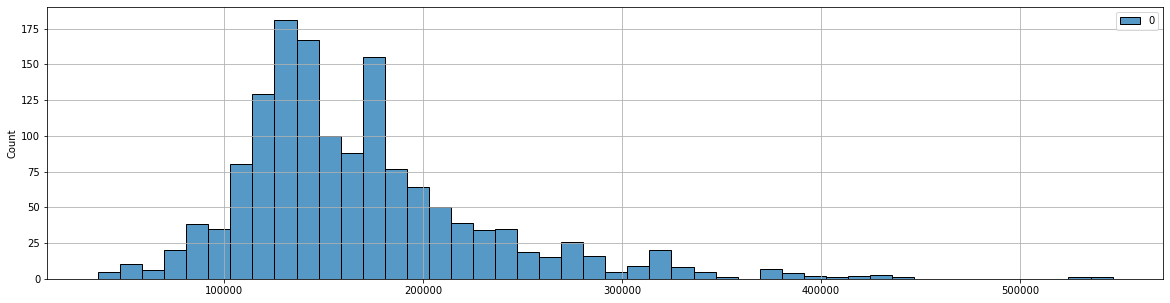

Total_SF        0.216018
GrLivArea       0.173316
OverallQual     0.113813
Neighborhood    0.090972
Fireplaces      0.070276
Foundation      0.069406
OverallCond     0.069337
LotArea         0.055891
BsmtFinSF1      0.045201
MSZoning        0.039248
HeatingQC      -0.036989
Condition1      0.029646
All_bath        0.029631
FireplaceQu     0.025680
Floors_no      -0.024641
dtype: float64


In [344]:
_ = lin_reg(Lasso(**lasso_rscv.best()))

## Ridge

In [345]:
%%time

param_distributions = {
    "alpha"        : uniform(0.0001, 1),
    "fit_intercept": [True, False],
    "normalize"    : [True, False],
    "max_iter"     : [100_000],
    elastic_rscv"          : [0.00001]
}

ridge_rscv = cmd_rscv(Ridge(), param_distributions, 500, random_state = 1854)

ridge_rscv.doit()

ridge_rscv.df()

Fitting 50 folds for each of 500 candidates, totalling 25000 fits
Wall time: 3min 26s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_fit_intercept,param_max_iter,param_normalize,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,split20_test_score,split21_test_score,split22_test_score,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,split30_test_score,split31_test_score,split32_test_score,split33_test_score,split34_test_score,split35_test_score,split36_test_score,split37_test_score,split38_test_score,split39_test_score,split40_test_score,split41_test_score,split42_test_score,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score
299,0.018716,0.007655,0.011440,0.006672,0.021497,True,100000,True,0.00001,"{'alpha': 0.021497108659136354, 'fit_intercept...",-0.152508,-0.172289,-0.163046,-0.175973,-0.154158,-0.162107,-0.158147,-0.162642,-0.168200,-0.183735,-0.168902,-0.157740,-0.157280,-0.165283,-0.177398,-0.160227,-0.165741,-0.169013,-0.174318,-0.161145,-0.160413,-0.170140,-0.155231,-0.179962,-0.159942,-0.169397,-0.154698,-0.173144,-0.154921,-0.172333,-0.165826,-0.173172,-0.156091,-0.179988,-0.156504,-0.153758,-0.166691,-0.176230,-0.160831,-0.165739,-0.152992,-0.158421,-0.167787,-0.179674,-0.168261,-0.156846,-0.182441,-0.144674,-0.159341,-0.169163,-0.165089,0.008951,1
426,0.011794,0.003644,0.006739,0.002776,0.022261,True,100000,True,0.00001,"{'alpha': 0.022260764289665624, 'fit_intercept...",-0.152515,-0.172322,-0.163089,-0.175970,-0.154133,-0.162095,-0.158158,-0.162628,-0.168201,-0.183773,-0.168849,-0.157744,-0.157284,-0.165315,-0.177412,-0.160129,-0.165803,-0.168982,-0.174323,-0.161156,-0.160383,-0.170158,-0.155228,-0.180001,-0.159925,-0.169466,-0.154699,-0.173173,-0.154943,-0.172235,-0.165863,-0.173154,-0.156145,-0.179966,-0.156433,-0.153765,-0.166651,-0.176237,-0.160816,-0.165749,-0.153032,-0.158343,-0.167786,-0.179645,-0.168297,-0.156869,-0.182470,-0.144699,-0.159343,-0.169114,-0.165089,0.008953,2
69,0.021745,0.009939,0.014275,0.010935,0.030605,True,100000,True,0.00001,"{'alpha': 0.030605326132280408, 'fit_intercept...",-0.152643,-0.172659,-0.163581,-0.176052,-0.154011,-0.161994,-0.158283,-0.162588,-0.168287,-0.184172,-0.168460,-0.157830,-0.157345,-0.165673,-0.177540,-0.159220,-0.166462,-0.168700,-0.174446,-0.161277,-0.160152,-0.170397,-0.155178,-0.180458,-0.159851,-0.170240,-0.154710,-0.173452,-0.155181,-0.171282,-0.166294,-0.172965,-0.156679,-0.179835,-0.155822,-0.153912,-0.166365,-0.176315,-0.160759,-0.165898,-0.153500,-0.157608,-0.167796,-0.179440,-0.168679,-0.157137,-0.182751,-0.145001,-0.159401,-0.168612,-0.165138,0.008977,3
108,0.014203,0.004072,0.007910,0.003974,0.004371,True,100000,True,0.00001,"{'alpha': 0.004370796767234964, 'fit_intercept...",-0.153711,-0.171785,-0.162068,-0.176434,-0.155214,-0.162727,-0.158218,-0.163033,-0.168759,-0.182949,-0.170944,-0.157912,-0.157278,-0.165145,-0.177109,-0.164080,-0.164316,-0.169884,-0.174716,-0.161194,-0.161783,-0.170091,-0.155982,-0.179190,-0.160783,-0.167582,-0.154663,-0.172739,-0.155388,-0.175196,-0.165177,-0.174062,-0.155118,-0.180945,-0.158674,-0.153765,-0.168314,-0.176013,-0.162488,-0.166312,-0.152421,-0.161099,-0.168099,-0.180679,-0.167634,-0.156367,-0.182277,-0.144583,-0.159310,-0.170599,-0.165496,0.008888,4
429,0.013362,0.002815,0.008859,0.003661,0.059877,True,100000,True,0.00001,"{'alpha': 0.059877495672330264, 'fit_intercept...",-0.153225,-0.173712,-0.165228,-0.176376,-0.154209,-0.161838,-0.158678,-0.162876,-0.169048,-0.185365,-0.168142,-0.158605,-0.157588,-0.166386,-0.177944,-0.157588,-

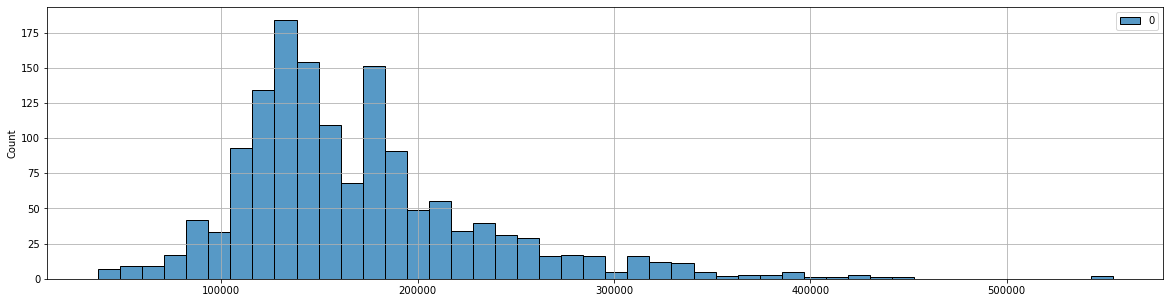

Total_SF        0.227803
GrLivArea       0.211196
OverallQual     0.114678
Neighborhood    0.085038
Floors_no      -0.080947
Foundation      0.077415
Fireplaces      0.075132
OverallCond     0.073990
GarageYrBlt     0.070779
BsmtFinSF1      0.066737
LotArea         0.063775
Age_Garage      0.050238
HeatingQC      -0.049329
GarageArea     -0.041335
MSZoning        0.040865
dtype: float64


In [346]:
_ = lin_reg(Ridge(**ridge_rscv.best()))

## ElasticNet

In [348]:
%%time

param_distributions = {
    "alpha"        : uniform(0.0001, 1),
    "l1_ratio"     : uniform(0.00001,0.99999),
    "fit_intercept": [True, False],
    "normalize"    : [True, False],
    "max_iter"     : [100_000],
    "tol"          : [0.00001]
}

elastic_rscv = cmd_rscv(ElasticNet(), param_distributions, 500, random_state = 1854)

elastic_rscv.doit()

elastic_rscv.df()

Fitting 50 folds for each of 500 candidates, totalling 25000 fits
Wall time: 4min 1s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_fit_intercept,param_l1_ratio,param_max_iter,param_normalize,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,split20_test_score,split21_test_score,split22_test_score,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,split30_test_score,split31_test_score,split32_test_score,split33_test_score,split34_test_score,split35_test_score,split36_test_score,split37_test_score,split38_test_score,split39_test_score,split40_test_score,split41_test_score,split42_test_score,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score
72,0.036625,0.003633,0.006871,0.002580,0.004371,True,0.347754,100000,False,0.00001,"{'alpha': 0.004370796767234964, 'fit_intercept...",-0.154711,-0.171454,-0.163185,-0.176241,-0.153212,-0.161697,-0.158565,-0.163399,-0.168425,-0.182824,-0.168628,-0.158702,-0.157089,-0.166223,-0.175985,-0.161362,-0.164582,-0.168582,-0.174340,-0.162278,-0.159685,-0.169959,-0.155731,-0.180051,-0.160393,-0.169773,-0.155411,-0.173359,-0.155566,-0.171228,-0.164364,-0.173443,-0.156514,-0.182377,-0.153823,-0.152812,-0.166258,-0.176676,-0.160657,-0.168150,-0.152455,-0.157727,-0.168065,-0.179840,-0.168184,-0.156412,-0.183259,-0.145286,-0.159654,-0.169424,-0.165160,0.008985,1
404,0.047781,0.005449,0.007180,0.001804,0.001509,True,0.410124,100000,False,0.00001,"{'alpha': 0.0015090848515170285, 'fit_intercep...",-0.154314,-0.171208,-0.162065,-0.176262,-0.154399,-0.162078,-0.158027,-0.163062,-0.168551,-0.182607,-0.170457,-0.158371,-0.156893,-0.165058,-0.176198,-0.163700,-0.164173,-0.169192,-0.174452,-0.161450,-0.160764,-0.169987,-0.155555,-0.179289,-0.160759,-0.167943,-0.154728,-0.172808,-0.155269,-0.173902,-0.164394,-0.173748,-0.155211,-0.181597,-0.157008,-0.152964,-0.167454,-0.176055,-0.161724,-0.166799,-0.151978,-0.160258,-0.167778,-0.180202,-0.167458,-0.155946,-0.182449,-0.144620,-0.159210,-0.170049,-0.165208,0.008909,2
191,0.034410,0.005289,0.008291,0.003027,0.004511,True,0.543517,100000,False,0.00001,"{'alpha': 0.004510638885288032, 'fit_intercept...",-0.156104,-0.172499,-0.164058,-0.177102,-0.153088,-0.162131,-0.158491,-0.163825,-0.169234,-0.182925,-0.167854,-0.159557,-0.157208,-0.167800,-0.176237,-0.161078,-0.164848,-0.169230,-0.174830,-0.163254,-0.159687,-0.170813,-0.156770,-0.180988,-0.160910,-0.170770,-0.156491,-0.174469,-0.156942,-0.169595,-0.164622,-0.174035,-0.158104,-0.183294,-0.152081,-0.153265,-0.166744,-0.177265,-0.160570,-0.169992,-0.153732,-0.156645,-0.169146,-0.179830,-0.169462,-0.157334,-0.183805,-0.146545,-0.160089,-0.169713,-0.165701,0.009011,3
441,0.030607,0.007657,0.010145,0.007162,0.016637,False,0.154709,100000,False,0.00001,"{'alpha': 0.016637446153236157, 'fit_intercept...",-0.156597,-0.174747,-0.165468,-0.177704,-0.154124,-0.162178,-0.159019,-0.164944,-0.170349,-0.183745,-0.167916,-0.161150,-0.158659,-0.168286,-0.177341,-0.160173,-0.166297,-0.169930,-0.176027,-0.165059,-0.159952,-0.172074,-0.158106,-0.181886,-0.161435,-0.172340,-0.156936,-0.174954,-0.158046,-0.169852,-0.165784,-0.173303,-0.160197,-0.183797,-0.152448,-0.154731,-0.166381,-0.178581,-0.161073,-0.170866,-0.155146,-0.156634,-0.170137,-0.180458,-0.170275,-0.158488,-0.185257,-0.148099,-0.161281,-0.170031,-0.166565,0.008987,4
363,0.030306,0.003631,0.007156,0.001669,0.039459,False,0.038913,100000,True,0.00001,"{'alpha': 0.03945890059773484, 'fit_intercept'...",-0.156707,-0.176404,-0.167652,-0.177861,-0.155401,-0.162353,-0.160615,-0.166029,-0.171241,-0.18

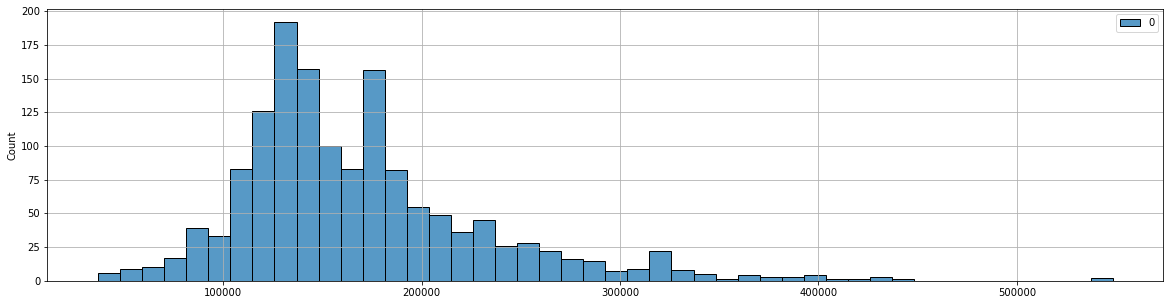

Total_SF        0.231284
GrLivArea       0.199214
OverallQual     0.112765
Neighborhood    0.087513
OverallCond     0.073184
Fireplaces      0.072017
Foundation      0.070411
Floors_no      -0.063021
GarageYrBlt     0.061203
BsmtFinSF1      0.059363
LotArea         0.058655
HeatingQC      -0.045355
Age_Garage      0.041321
MSZoning        0.040580
GarageArea     -0.037251
dtype: float64


In [349]:
_ = lin_reg(ElasticNet(**elastic_rscv.best()))

In [351]:
best_linear_models = [
    ("lin_regr", LinearRegression(**lr_gscv.best_params_)),
    ("lasso"   , Lasso(**lasso_rscv.best())),
    ("ridge"   , Ridge(**ridge_rscv.best())),
    ("elastic" , ElasticNet(**elastic_rscv.best()))
]

## *Linear Model Stack*

In [352]:
from sklearn.ensemble import StackingRegressor

In [361]:
%%time

linear_stack = StackingRegressor(
    best_linear_models,
    final_estimator = None,
    cv              = 5,
    n_jobs          = -2,
    passthrough     = False,
    verbose         = 1,
)

linear_stack.fit(X_train_, y_train_)

Wall time: 8.2 s


StackingRegressor(cv=5,
                  estimators=[('lin_regr', LinearRegression(normalize=True)),
                              ('lasso',
                               Lasso(alpha=0.003672588612562044,
                                     fit_intercept=False, max_iter=100000,
                                     normalize=True, tol=1e-05)),
                              ('ridge',
                               Ridge(alpha=0.021497108659136354,
                                     max_iter=100000, normalize=True,
                                     tol=1e-05)),
                              ('elastic',
                               ElasticNet(alpha=0.004370796767234964,
                                          l1_ratio=0.3477540204428681,
                                          max_iter=100000, tol=1e-05))],
                  n_jobs=-2, verbose=1)

In [367]:
_ = y_transform.inverse_transform(linear_stack.predict(X_test_).reshape(-1,1)).astype(np.int64)

my_sub(_, "lin_stack")

## *Linear Model Vote*

In [373]:
from sklearn.ensemble import VotingRegressor

In [375]:
%%time

linear_vote = VotingRegressor(
    best_linear_models,
    n_jobs          = -2,
    verbose         = True,
)

linear_vote.fit(X_train_, y_train_)

Wall time: 71 ms


VotingRegressor(estimators=[('lin_regr', LinearRegression(normalize=True)),
                            ('lasso',
                             Lasso(alpha=0.003672588612562044,
                                   fit_intercept=False, max_iter=100000,
                                   normalize=True, tol=1e-05)),
                            ('ridge',
                             Ridge(alpha=0.021497108659136354, max_iter=100000,
                                   normalize=True, tol=1e-05)),
                            ('elastic',
                             ElasticNet(alpha=0.004370796767234964,
                                        l1_ratio=0.3477540204428681,
                                        max_iter=100000, tol=1e-05))],
                n_jobs=-2, verbose=True)

In [376]:
_ = y_transform.inverse_transform(linear_vote.predict(X_test_).reshape(-1,1)).astype(np.int64)

# SVR

In [378]:
from sklearn.svm import SVR